In [ ]:
import os
import torch
import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from torchvision.transforms import ToTensor
from PIL import Image
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt
import torch.optim as optim

## Utility Functions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


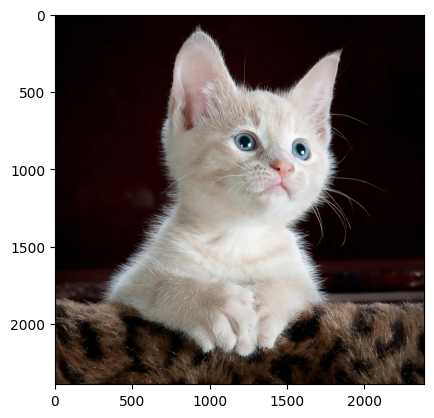

In [ ]:
img_path = "/content/drive/MyDrive/test_img.png"
img = Image.open(img_path).convert('RGB')
plt.imshow(img)
plt.axis('on')
plt.show()

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])
img_tensor = transform(img)
print(img_tensor.shape)

torch.Size([3, 2390, 2390])


In [ ]:
def forward_spc(x: torch.Tensor, H: torch.Tensor) -> torch.Tensor:
    r"""

    Forward propagation through the Single Pixel Camera (SPC) model.

    For more information refer to: Optimized Sensing Matrix for Single Pixel Multi-Resolution Compressive Spectral Imaging 10.1109/TIP.2020.2971150

    Args:
        x (torch.Tensor): Input image tensor of size (B, L, M, N).
        H (torch.Tensor): Measurement matrix of size (S, M*N).

    Returns:
        torch.Tensor: Output measurement tensor of size (B, S, L).
    """
    B, L, M, N = x.size()
    x = x.contiguous().view(B, L, M * N)
    x = x.permute(0, 2, 1)

    # measurement
    H = H.unsqueeze(0).repeat(B, 1, 1)
    y = torch.bmm(H, x)
    return y


def backward_spc(y: torch.Tensor, H: torch.Tensor, pinv= False) -> torch.Tensor:
    r"""

    Inverse operation to reconstruct the image from measurements.

    For more information refer to: Optimized Sensing Matrix for Single Pixel Multi-Resolution Compressive Spectral Imaging  10.1109/TIP.2020.2971150

    Args:
        y (torch.Tensor): Measurement tensor of size (B, S, L).
        H (torch.Tensor): Measurement matrix of size (S, M*N).
        pinv (bool): Boolean, if True the pseudo-inverse of H is used, otherwise the transpose of H is used, defaults to False.
    Returns:
        torch.Tensor: Reconstructed image tensor of size (B, L, M, N).
    """

    Hinv   = torch.pinverse(H) if pinv else torch.transpose(H, 0, 1)
    Hinv   = Hinv.unsqueeze(0).repeat(y.shape[0], 1, 1)

    x = torch.bmm(Hinv, y)
    x = x.permute(0, 2, 1)
    b, c, hw = x.size()
    h = int(np.sqrt(hw))
    x = x.reshape(b, c, h, h)
    x = x/x.max() # normalizetion step to avoid numerical issues
    return x

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_channels))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


In [ ]:
class SPC(nn.Module):
    def __init__(self, pinv:bool = False, num_measurements:int=100, img_size:tuple=(32,32), trainable:bool=True):
        super(SPC, self).__init__()
        self.pinv = pinv
        M, N = img_size
        H = torch.randn(num_measurements, M*N)
        self.H = nn.Parameter(H, requires_grad=trainable)

    def forward(self, x: torch.Tensor) -> torch:
        y = forward_spc(x, self.H)
        x_hat = backward_spc(y, self.H, self.pinv)
        return x_hat

    def forward_pass(self, x: torch.Tensor) -> torch.Tensor:
        return forward_spc(x, self.H)

    def backward_pass(self, y: torch.Tensor) -> torch.Tensor:
        return backward_spc(y, self.H, self.pinv)

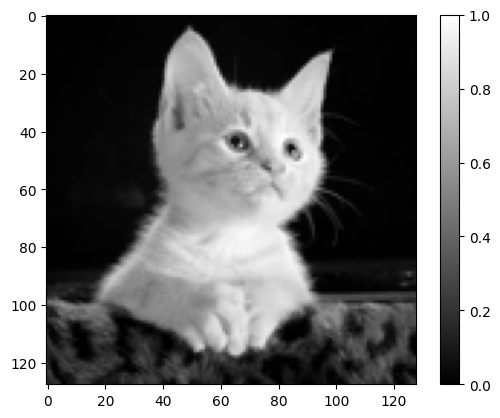

In [ ]:
img = img.resize((128, 128))
img = img.convert('L')
img = np.array(img)
img = torch.tensor(img).float()
img = (img - img.min()) / (img.max() - img.min())
plt.imshow(img, cmap='gray')
plt.colorbar()
plt.show()

In [ ]:
spc = SPC(
    pinv=False,
    num_measurements=6000, # number of total measurements = 128*128, compression ration = 6000/(128*128)
    img_size=(128, 128),
    trainable=True
)
y = spc.forward_pass(img.unsqueeze(0).unsqueeze(0))
print(y.shape)
x_hat = spc.backward_pass(y)
x_hat = x_hat.squeeze()
print(x_hat.shape)

torch.Size([1, 6000, 1])
torch.Size([128, 128])


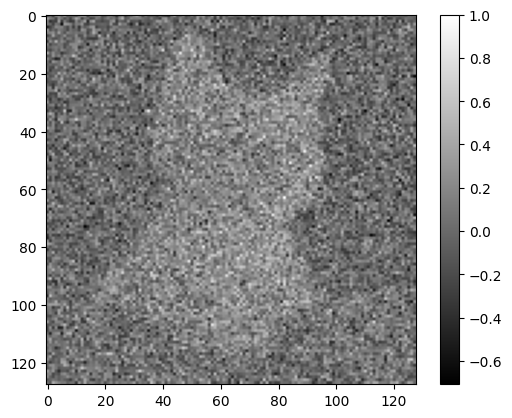

In [ ]:
plt.imshow(x_hat.squeeze().squeeze().detach().numpy(), cmap='gray')
plt.colorbar()
plt.show()

In [ ]:
class E2E(nn.Module):
    def __init__(self, pinv:bool=False, num_measurements:int=100, img_size:tuple=(32,32), trainable:bool=True, num_channels:int=1):
        super(E2E, self).__init__()
        self.spc = SPC(pinv, num_measurements, img_size, trainable)
        self.unet = UNet(num_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_hat = self.spc(x)
        x_hat = self.unet(x_hat)
        return x_hat

In [ ]:
e2e_spc = E2E(
    pinv=False,
    num_measurements=6000,
    img_size=(128, 128),
    trainable=True,
    num_channels=1
)

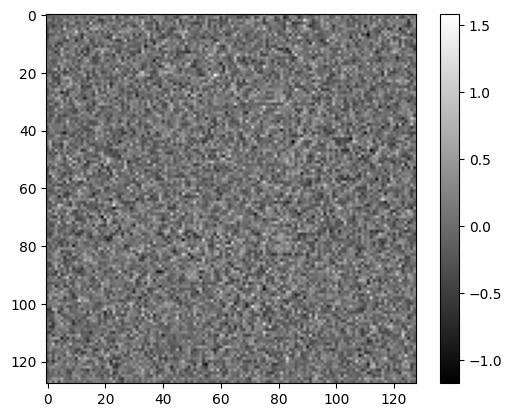

In [ ]:
x_hat = e2e_spc(img.unsqueeze(0).unsqueeze(0))

plt.imshow(x_hat.squeeze().squeeze().detach().numpy(), cmap='gray')
plt.colorbar()
plt.show()

## Load data MNIST dataset

In [ ]:
#Dataloader tqdm

In [ ]:
batch_size = 32


x = datasets.MNIST(root="data", train=True, download=True, transform=ToTensor())
#x.data = x.data.type(torch.float32) / 255.0

x_train = x.data[:59400,:,:]
x_val = x.data[59400:,:,:]


x_test = datasets.MNIST(root="data", train=False, download=True, transform=ToTensor())
x_test.data = x_test.data.type(torch.float32) / 255.0

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.5MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 501kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.60MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.33MB/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
x_train = x_train.unsqueeze(1)
x_val = x_val.unsqueeze(1)
x_test = x_test.data.unsqueeze(1)

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

torch.Size([59400, 1, 28, 28])
torch.Size([600, 1, 28, 28])
torch.Size([10000, 1, 28, 28])


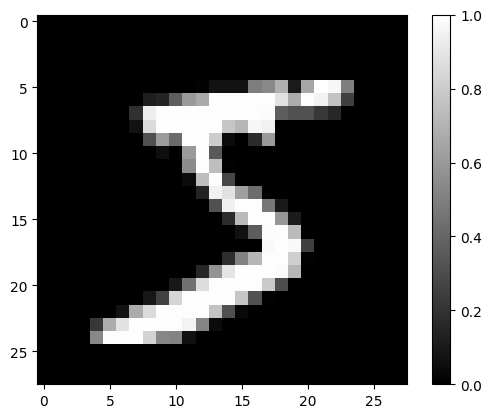

In [ ]:
x_example = x_train[0]
plt.imshow(x_example.squeeze().squeeze().detach().numpy(), cmap='gray')
plt.colorbar()
plt.show()


In [ ]:
transform = transforms.Compose([
    transforms.Resize((32, 32), interpolation=transforms.InterpolationMode.BICUBIC)
])

x_train = torch.stack([transform(x) for x in x_train])
x_val = torch.stack([transform(x) for x in x_val])
x_test = torch.stack([transform(x) for x in x_test])


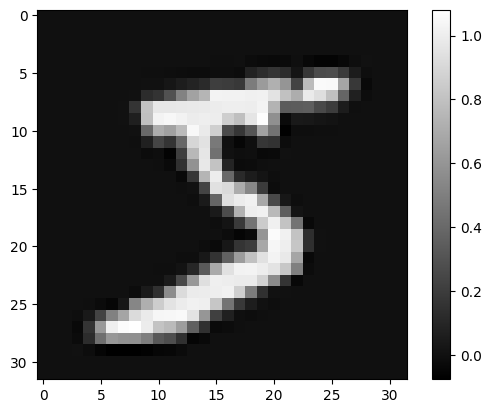

In [ ]:
x_example = x_train[0]
plt.imshow(x_example.squeeze().squeeze().detach().numpy(), cmap='gray')
plt.colorbar()
plt.show()

In [ ]:
spc = SPC(
    pinv=False,
    num_measurements=235,
    img_size=(32, 32),
    trainable=True
)

y_train = spc.forward_pass(x_train[0].unsqueeze(0))
print(y_train.shape)
x_hat = spc.backward_pass(y_train)
print(x_hat.shape)

torch.Size([1, 235, 1])
torch.Size([1, 1, 32, 32])


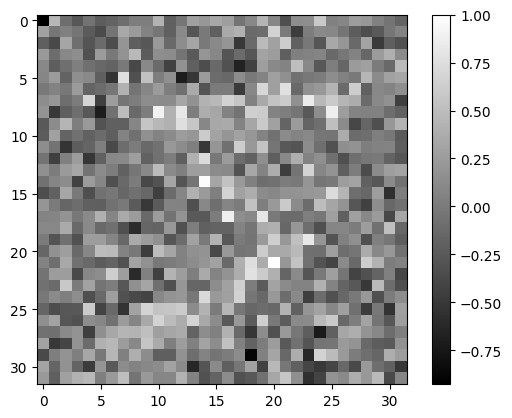

In [ ]:
plt.imshow(x_hat.squeeze().squeeze().detach().numpy(), cmap='gray')
plt.colorbar()
plt.show()

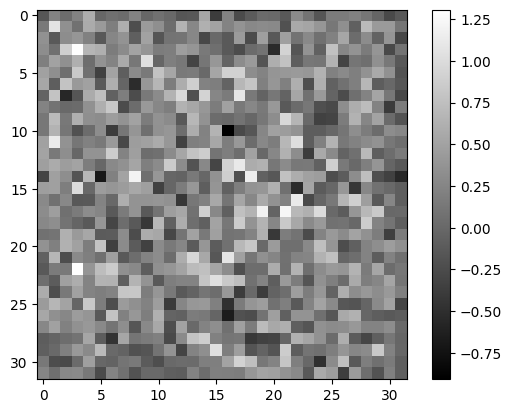

In [ ]:
e2e_spc = E2E(
    pinv=False,
    num_measurements=235,
    img_size=(32, 32),
    trainable=True,
    num_channels=1
)

x_hat = e2e_spc(x_train[0].unsqueeze(0))

plt.imshow(x_hat.squeeze().squeeze().detach().numpy(), cmap='gray')
plt.colorbar()
plt.show()

In [ ]:
num_epochs = 50  # Número de épocas
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modelo
model = E2E(pinv=False, num_measurements=235, img_size=(32, 32), trainable=True, num_channels=1).to(device)

# Optimización y pérdida
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# DataLoader
train_loader = DataLoader(x_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(x_val, batch_size=batch_size, shuffle=False)

# Listas para almacenar las métricas
train_losses = []
val_losses = []
train_psnrs = []
val_psnrs = []
train_ssims = []
val_ssims = []
train_pixel_accs = []
val_pixel_accs = []

# Bucle de entrenamiento
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_psnr = 0.0
    train_ssim = 0.0
    train_pixel_acc = 0.0

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        x_hat = model(batch)
        loss = criterion(x_hat, batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        x_hat_np = x_hat.detach().cpu().numpy()
        batch_np = batch.cpu().numpy()

        train_psnr += psnr(batch_np, x_hat_np, data_range=1.0)
        train_ssim += ssim(batch_np.squeeze(), x_hat_np.squeeze(), data_range=1.0)
        train_pixel_acc += (torch.abs(x_hat - batch) < 0.1).float().mean().item()

    train_loss /= len(train_loader)
    train_psnr /= len(train_loader)
    train_ssim /= len(train_loader)
    train_pixel_acc /= len(train_loader)

    train_losses.append(train_loss)
    train_psnrs.append(train_psnr)
    train_ssims.append(train_ssim)
    train_pixel_accs.append(train_pixel_acc)

    model.eval()
    val_loss = 0.0
    val_psnr = 0.0
    val_ssim = 0.0
    val_pixel_acc = 0.0
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            x_hat = model(batch)
            loss = criterion(x_hat, batch)
            val_loss += loss.item()

            x_hat_np = x_hat.cpu().numpy()
            batch_np = batch.cpu().numpy()

            val_psnr += psnr(batch_np, x_hat_np, data_range=1.0)
            val_ssim += ssim(batch_np.squeeze(), x_hat_np.squeeze(), data_range=1.0)
            val_pixel_acc += (torch.abs(x_hat - batch) < 0.1).float().mean().item()

    val_loss /= len(val_loader)
    val_psnr /= len(val_loader)
    val_ssim /= len(val_loader)
    val_pixel_acc /= len(val_loader)

    val_losses.append(val_loss)
    val_psnrs.append(val_psnr)
    val_ssims.append(val_ssim)
    val_pixel_accs.append(val_pixel_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.6f} - Val Loss: {val_loss:.6f} - PSNR: {val_psnr:.2f} - SSIM: {val_ssim:.4f} - Pixel Acc: {val_pixel_acc:.4f}")

# Gráficas de las métricas
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, train_psnrs, label="Train PSNR")
plt.plot(epochs, val_psnrs, label="Val PSNR")
plt.xlabel("Epochs")
plt.ylabel("PSNR")
plt.title("Peak Signal to Noise Ratio (PSNR)")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, train_ssims, label="Train SSIM")
plt.plot(epochs, val_ssims, label="Val SSIM")
plt.xlabel("Epochs")
plt.ylabel("SSIM")
plt.title("Structural Similarity Index (SSIM)")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, train_pixel_accs, label="Train Pixel Accuracy")
plt.plot(epochs, val_pixel_accs, label="Val Pixel Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Pixel Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/200 - Train Loss: 0.006395 - Val Loss: 0.003959 - PSNR: 24.42 - SSIM: 0.9579 - Pixel Acc: 0.9158
Epoch 2/200 - Train Loss: 0.001571 - Val Loss: 0.003024 - PSNR: 26.44 - SSIM: 0.9690 - Pixel Acc: 0.9312
Epoch 3/200 - Train Loss: 0.001032 - Val Loss: 0.002760 - PSNR: 27.14 - SSIM: 0.9662 - Pixel Acc: 0.9353
Epoch 4/200 - Train Loss: 0.000794 - Val Loss: 0.002601 - PSNR: 27.97 - SSIM: 0.9749 - Pixel Acc: 0.9416
Epoch 5/200 - Train Loss: 0.000659 - Val Loss: 0.002570 - PSNR: 27.73 - SSIM: 0.9628 - Pixel Acc: 0.9382
Epoch 6/200 - Train Loss: 0.000554 - Val Loss: 0.002376 - PSNR: 28.67 - SSIM: 0.9687 - Pixel Acc: 0.9450
Epoch 7/200 - Train Loss: 0.000483 - Val Loss: 0.002446 - PSNR: 28.62 - SSIM: 0.9774 - Pixel Acc: 0.9428
Epoch 8/200 - Train Loss: 0.000421 - Val Loss: 0.002680 - PSNR: 28.02 - SSIM: 0.9735 - Pixel Acc: 0.9369
Epoch 9/200 - Train Loss: 0.000375 - Val Loss: 0.002415 - PSNR: 29.29 - SSIM: 0.9788 - Pixel Acc: 0.9464
Epoch 10/200 - Train Loss: 0.000339 - Val Loss: 0.00266

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), "e2e_spc.pth")
print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.


<ipython-input-24-8644838d1821>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filepath, map_location=device))


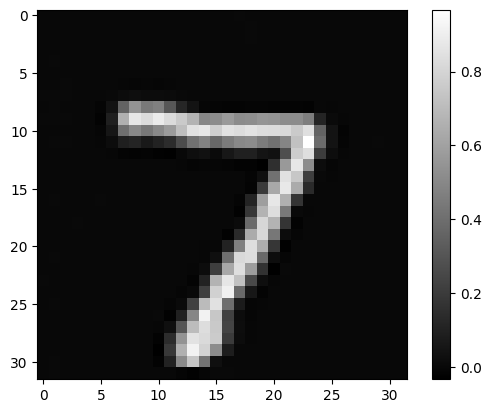

In [ ]:
def load_model(filepath):
    model = E2E(pinv=False, num_measurements=235, img_size=(32, 32), trainable=True, num_channels=1).to(device)
    model.load_state_dict(torch.load(filepath, map_location=device))
    model.eval()
    return model

val_loader_T = DataLoader(x_test, batch_size=batch_size, shuffle=False)
x_reference = x_test[0].unsqueeze(0)
model = load_model("e2e_spc.pth")
batch_example = next(iter(val_loader_T)).to(device)
x_hat_example = model(batch_example)

plt.imshow(x_reference.squeeze().cpu().detach().numpy(), cmap='gray')
plt.colorbar()
plt.show()

## Example

In [ ]:
# plt.imshow(x_hat.squeeze().squeeze().detach().numpy(), cmap='gray')
# plt.colorbar()
# plt.show()

In [ ]:
# print(x_hat.shape)
# x_hat = e2e_spc(img.unsqueeze(0).unsqueeze(0))

# plt.imshow(x_hat.squeeze().squeeze().detach().numpy(), cmap='gray')
# plt.colorbar()
# plt.show()